### Import Packages

In [1]:
# import packages, I mostly use the same packages all the time, not all of these are usefull I suppose
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const
import pandas as pd 
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from itertools import islice
# from scipy import stats
# from sklearn.neighbors import LocalOutlierFactor
import datetime
import fabio
import math
import random
import os
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from sys import platform 
from os.path import exists
import meera_func as mfc
# %matplotlib widget
# import ipywidgets as widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) #this is for a constant figure size


/Users/meera94/miniconda3/envs/LX99/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import data

In [2]:
#import data
#path = '/Users/meera94/Desktop/LCLS MEC LX99' # Main XRD data folder
#path = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99'
path ='/Volumes/T7/LX99'
data_files = 'scratch'
#data_files = 'scratch'
#xrd_data_folder_name = 'Raw_data_LX99'                   # Name of folder containing XRD run folders
xrd_data_folder_name = 'run'
calibration_folder_name = 'XRD_calibration_files'   # Name of folder containing calibration (.poni) files
energy_file_name = 'Energies.csv'
results_save_dir = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/Results/Analysis_fit_results'

##importing 
#fit_params_file = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/Results/Peakfit_boundsnguess.xlsx'
fit_params_file = '/Users/meera94/Desktop/LCLS MEC LX99/Peakfit_boundsnguess.xlsx'

In [3]:
#Read energies in KeV
if platform == "linux" or platform == "linux2":
    concat_4 = "{0}/{1}/{2}/{3}"
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}" ### this is to precudurally generate a path for your platform type (i.e linux in this line) to your directory. I would never use something so uneccesarily complicated cos I am not a CS major. What a fucking pain
elif platform == "darwin": # apparently darwin is mac. 
    concat_4 = "{0}/{1}/{2}/{3}"
    concat_3 = "{0}/{1}/{2}"
    concat_2 = "{0}/{1}"
elif platform == "win64":
    concat_4 = "{0}\\{1}\\{2}\\{3}"
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"
else:
    concat_4 = "{0}\\{1}\\{2}\\{3}"
    concat_3 = "{0}\\{1}\\{2}"
    concat_2 = "{0}\\{1}"

## Open and store runs

In [4]:
## opening runs from tiff files tand saving them to a dictionary. We will rotate the images as required by the detector
#Runs = [140, 143, 146]#, 149, 152, 157, 160, 163, 166, 169, 173, 176, 182, 185, 179, 237, 240, 243, 249, 252, 255, 260, 263, 270, 273, 276, 282, 285, 288, 291, 294, 297, 300, 305, 311, 313, 316, 319, 327, 330, 336, 333, 339] 
#Runs = [139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 157, 159, 160, 162, 163, 165, 166, 168, 169, 172, 173, 175, 176, 178, 181, 182, 184, 185, 179, 234, 237, 239, 240, 242, 243, 248, 249, 251, 252, 254, 255, 259, 260, 262, 263, 269, 270, 272, 273, 275, 276, 281, 282, 284, 284, 285, 287, 288, 290, 291, 293, 294, 296, 297, 299, 300, 302, 304, 305, 307, 310, 311, 312, 313, 315, 316, 318, 319, 326, 327, 329,  330, 335,  336, 332, 333, 338, 339] 
#Runs = [ 140, 141, 144, 147, 150, 153, 158, 161, 164] #, 141, 144, 147, 150, 153, 158, 161, 164, 419, 446, 460, 600, 612, 615] # what is wrong with 150?
#Runs = [ 413, 416, 419, 422, 425, 428, 431, 434, 437]
Runs = [ 446, 600, 612, 615, 606, 609, 603]
#Runs = [218, 219]#, 448, 449, 539, 540, 541]#, 67, 70, 88, 116, 117, 118, 127, 128, 129]
dark_run = [124]
#Runs = [249, 250, 244]
Quads = [0, 1, 2, 3]
Run_key_list= [] #empty key list which will be used to create our dictonary, gonna make this a string
Quad_key_list= []
darkrun_key_list = []

for j in Runs:
    keys = 'Run ' + str(j) 
    Run_key_list.append(keys) #so now we have a string of keys that we want
    # j = j + 1
for j in dark_run:
    keys = 'Run ' + str(j) 
    darkrun_key_list.append(keys)
 
for i in Quads:
    keys = 'Quad' + str((i))
    Quad_key_list.append(keys) #so now we have a string of keys that we want
    # i = i +1

Run_images = dict.fromkeys(Run_key_list) # this stores all the runs listed above. Dictionary with keys ready for our data now!
# Quad_images = dict.fromkeys(Quad_key_list) # this stores all the images from all the quads.
rot_mat = [-1, 1, 0, 1]  # The MEC detectors have tilts and rotations associated with it. Since they are all some factor of 90 we will use the numpy rotate 90 function and using 1,0,-1 to determine
rot_angles = ["-90", "+90", "0", "+90"]
#rot_angles = ["-90","0", "+90", "-180"]
filter_sigma = 1
for j in Runs:
    # images_all_quads = []
    Quad_images = dict.fromkeys(Quad_key_list) # this stores all the images from all the quads.
    for i in Quads:
        #name_image = '/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/scratch/run' + str(j) + '/Run_' + str(j) + '_evt_1_Epix10kaQuad' + str(i)+ '.tiff'
        image_path = concat_3.format(path, data_files, xrd_data_folder_name)
        name_image = image_path + str(j) + '/Run_' + str(j) + '_evt_1_Epix10kaQuad' + str(i)+ '.tiff'
        print(name_image)
        images = np.rot90(np.flipud(fabio.open(name_image).data), rot_mat[i]) #fabio.open(name_image).data #apparently we need to flip up to down Rahul said. I asked why, he said try without flipping and then you will see. \../
        #images = scipy.ndimage.gaussian_filter(images, sigma=filter_sigma)
        Quad_images['Quad' + str((i))] = images #dictionary with all the quads for each run
        # i = i + 1
    Run_images['Run ' + str(j)] = Quad_images # adding the data to the appropriate keys. Final dictionary with all the runs and quads
    # j = j + 1


/Volumes/T7/LX99/scratch/run446/Run_446_evt_1_Epix10kaQuad0.tiff
/Volumes/T7/LX99/scratch/run446/Run_446_evt_1_Epix10kaQuad1.tiff
/Volumes/T7/LX99/scratch/run446/Run_446_evt_1_Epix10kaQuad2.tiff
/Volumes/T7/LX99/scratch/run446/Run_446_evt_1_Epix10kaQuad3.tiff
/Volumes/T7/LX99/scratch/run600/Run_600_evt_1_Epix10kaQuad0.tiff
/Volumes/T7/LX99/scratch/run600/Run_600_evt_1_Epix10kaQuad1.tiff
/Volumes/T7/LX99/scratch/run600/Run_600_evt_1_Epix10kaQuad2.tiff
/Volumes/T7/LX99/scratch/run600/Run_600_evt_1_Epix10kaQuad3.tiff
/Volumes/T7/LX99/scratch/run612/Run_612_evt_1_Epix10kaQuad0.tiff
/Volumes/T7/LX99/scratch/run612/Run_612_evt_1_Epix10kaQuad1.tiff
/Volumes/T7/LX99/scratch/run612/Run_612_evt_1_Epix10kaQuad2.tiff
/Volumes/T7/LX99/scratch/run612/Run_612_evt_1_Epix10kaQuad3.tiff
/Volumes/T7/LX99/scratch/run615/Run_615_evt_1_Epix10kaQuad0.tiff
/Volumes/T7/LX99/scratch/run615/Run_615_evt_1_Epix10kaQuad1.tiff
/Volumes/T7/LX99/scratch/run615/Run_615_evt_1_Epix10kaQuad2.tiff
/Volumes/T7/LX99/scratch/

In [5]:
dark_run_images =dict.fromkeys(darkrun_key_list)
for j in dark_run:
    dark_quad_images = dict.fromkeys(Quad_key_list)
    for i in Quads:
        dark_image_path = concat_3.format(path, data_files, xrd_data_folder_name)
        dark_name_image = dark_image_path + str(j) + '/Run_' + str(j) + '_evt_1_Epix10kaQuad' + str(i)+ '.tiff'
        print(dark_name_image)
        dark_images = np.rot90(np.flipud(fabio.open(dark_name_image).data), rot_mat[i])
        dark_quad_images['Quad' + str((i))] = dark_images
    dark_run_images['Run ' + str(j)] = dark_quad_images

/Volumes/T7/LX99/scratch/run124/Run_124_evt_1_Epix10kaQuad0.tiff
/Volumes/T7/LX99/scratch/run124/Run_124_evt_1_Epix10kaQuad1.tiff
/Volumes/T7/LX99/scratch/run124/Run_124_evt_1_Epix10kaQuad2.tiff
/Volumes/T7/LX99/scratch/run124/Run_124_evt_1_Epix10kaQuad3.tiff


In [6]:
#dark_images

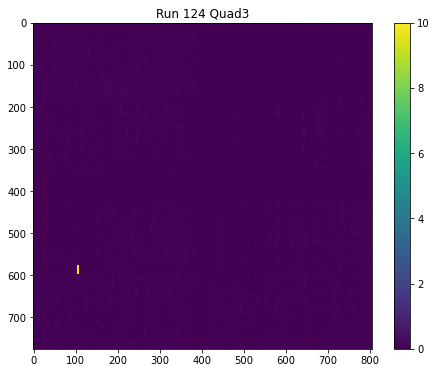

In [7]:
#i = [218, 219, 448, 449, 539, 540, 541]
plt.imshow(dark_run_images['Run 124'] ["Quad3"], vmin= 0, vmax = 10)
#plt.imshow(Run_images['Run 541'] ["Quad3"])
plt.title("Run 124 Quad3")
plt.colorbar()

In [8]:
# correct for polarization (lorentz polarization factor)
# correct for gain of every tile


## Energy import (Rahul Jangid & Karan Doss code)

In [9]:
# Read Gas Norms
def read_gas_norms(Runs, default_gas_norm = 0.7):
    import warnings
    run_numbers_list = ['run' + str(number) for number in Runs]
    print(run_numbers_list)
    gas_norm_values = {} # Dict containing all gas_norm values
    # Make a list of paths of all .txt files
    for run in run_numbers_list:
        gas_norm_values[run] = {'event':[], 'value':[]}
        text_file_name = (run + '_Bld.txt')
        # print(text_file_name)
        text_file_path = concat_4.format(path, data_files, run, text_file_name) 
        # print(text_file_path)
        header_bool = True
        
        print(text_file_path)
        #if text_file_path
        try:
            data = open(text_file_path)
            event_counter = 0
            for dat in data:
                if header_bool == True:
                    header_bool = False
                else:
                    gas_norm_values[run]['event'].append(event_counter)
                    try:
                        gas_norm_values[run]['value'].append(float(dat.split(' ')[1]))
                    except:
                        warnings.warn(run + " has no value for gas norm, set to " + str(default_gas_norm) + " by default.")
                        gas_norm_values[run]['value'].append(float(default_gas_norm))
                    event_counter += 1
                
        except:
            warnings.warn(run + " has no .txt file. Values set to defaults.")
            gas_norm_values[run]['event'] = [0]
            gas_norm_values[run]['value'] = [default_gas_norm]         

    # Remove negative and non-positive value for gas norm energies
    # Raise warnings and exceptions in such edge cases
    ref_run_bool = True
    for runs in gas_norm_values:
        if ref_run_bool == True: 
            ref_run_bool = False
            old_events = gas_norm_values[runs]['event']
            old_values = gas_norm_values[runs]['value']
            nan_idx = [idx for idx, val in enumerate(old_values) if np.isnan(val) == True]
            neg_idx = [idx for idx, val in enumerate(old_values) if val <= 0]
            remove_idx = nan_idx + neg_idx
            new_events = [evt for idx, evt in enumerate(old_events) if idx not in remove_idx]
            new_values = [val for idx, val in enumerate(old_values) if idx not in remove_idx]
            # Warn if there are multiple values
            if len(nan_idx) > 1: warnings.warn("There are" + str(len(nan_idx)) + "nan values in " + runs)
            elif len(new_values) == 0: raise Exception(runs + "contains only nan/ non-positive gas norm energy values!")
            gas_norm_values[runs]['event'] = new_events
            gas_norm_values[runs]['value'] = new_values
        else:
            if np.isnan(gas_norm_values[runs]['value'][0]) == True:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an nan gas norm energy value.")
            elif gas_norm_values[runs]['value'][0] <= 0:
                gas_norm_values[runs]['value'][0] = default_gas_norm
                #raise Exception(runs + " has an zero or negative gas norm energy value.")

    # Calculate the appropriate event for the reference
    shot_value = gas_norm_values[run_numbers_list[1]]['value'][0]
    diffs = [np.abs(val - shot_value) for val in gas_norm_values[run_numbers_list[0]]['value']]
    ref_event_idx = np.argmin(diffs)
    ref_event = gas_norm_values[run_numbers_list[0]]['event'][ref_event_idx]

    # Compile list of gas norm values
    gas_norms = []
    ref_run_bool = True
    for runs in gas_norm_values: 
        if ref_run_bool == True:
            gas_norms.append(gas_norm_values[runs]['value'][ref_event_idx])
            ref_run_bool = False
        else:
            gas_norms.append(gas_norm_values[runs]['value'][0])
    return gas_norms, ref_event



In [10]:
    
def read_energies(energy_file_name, run_numbers):
    file = open(energy_file_name)
    header_bool = False
    energies = []
    for data in file:
        if header_bool == False:
            header_bool = True
        elif int(data.split(',')[0]) in run_numbers:
            energies.append(float(data.split(',')[1]))
    return energies

energy_file_path = concat_2.format(path, energy_file_name)
E = read_energies(energy_file_path, Runs)
print("Energies (eV): ", E)

Gas_norm, ref_evt = read_gas_norms(Runs)
ref_evt_string = 'evt_' + str(int(ref_evt)) + '_'
print("Gas norms: ", Gas_norm)
print("Reference event: ", ref_evt, " of ", type(ref_evt))




Energies (eV):  [17204.3, 17205.3, 17205.2, 17208.1, 17205.8, 17208.7, 17204.4]
['run446', 'run600', 'run612', 'run615', 'run606', 'run609', 'run603']
/Volumes/T7/LX99/scratch/run446/run446_Bld.txt
/Volumes/T7/LX99/scratch/run600/run600_Bld.txt
/Volumes/T7/LX99/scratch/run612/run612_Bld.txt
/Volumes/T7/LX99/scratch/run615/run615_Bld.txt
/Volumes/T7/LX99/scratch/run606/run606_Bld.txt
/Volumes/T7/LX99/scratch/run609/run609_Bld.txt
/Volumes/T7/LX99/scratch/run603/run603_Bld.txt
Gas norms:  [0.741264, 1.21787, 0.900191, 1.18601, 1.23373, 1.16304, 1.30844]
Reference event:  0  of  <class 'int'>


In [11]:
# Convert energy (eV) to wavelength (m)
def get_wavelengths(E):
    lams = []
    h = const.h # Planck's constant in Js
    c = const.c # Speed of light in m/s
    e = const.e # Electron charge in Coulomb
    # E in eV
    return [h*c/(e*energy) for energy in E]
lams = get_wavelengths(E)
print("Wavelengths (m): ", lams)


Wavelengths (m):  [7.206581984341141e-11, 7.206163126083257e-11, 7.206205009718008e-11, 7.20499058194689e-11, 7.205953715212328e-11, 7.204739372131553e-11, 7.20654009632421e-11]


## Plotting the runs

Text(0.5, 1.0, 'Run 603 Quad0')

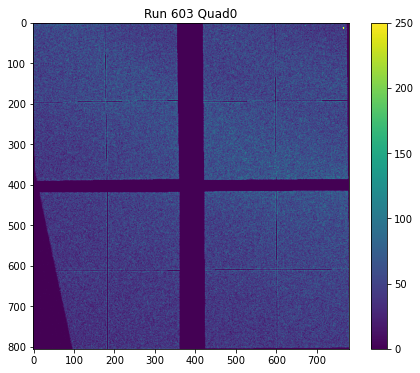

In [41]:
#plotting the quads we want. 
Run = Runs[6]
quad_2_plot = 0
plt.imshow(Run_images['Run ' +str(Run)] ['Quad' + str(quad_2_plot)], vmin = 0, vmax = 250)
plt.colorbar()
plt.title('Run ' +str(Run) + ' Quad' + str(quad_2_plot))


## Opening the calibration files

In [42]:
#open the calibration files. Using the same method as above, I am putting all the calibration files in an empty dictionary.
calibration = "/Users/meera94/Library/CloudStorage/OneDrive-UniversityofCalifornia,Davis/LX99/analysis/XRD_calibration_files/"
Quads = [0, 1, 2, 3]
calib_keys = []
for i in Quads:
    keys = 'Calib' + ' Quad' + str((i))
    calib_keys.append(keys) #so now we have a string of keys that we want
    # i = i +1
calib_all = dict.fromkeys(calib_keys)   

for i in Quads:
    calib = pyFAI.load (calibration + 'Quad'+ str(i) + '.poni')
    calib_all['Calib' + ' Quad' + str((i))] = calib
    # i = i + 1

## Creating triangle mask for quad 0

In [43]:
#This is using the first run in the run list to create this. We are only going to use Quad 0 since only quad 0 has this shadow issue that needs to be masked out.
def line_mask(x, m = 4.8, c = 345):
    y = m*x+c
    return y

edge_mask_width = 10

mask_tri = np.full(np.shape(Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[0])]), True)
for i in range(edge_mask_width, np.shape(Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[0])])[0]-edge_mask_width):
    for j in range(edge_mask_width, np.shape(Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[0])])[1]-edge_mask_width):
        # print([i, j])
        if i >= line_mask(j):
            mask_tri[i, j] = True
        else:
            mask_tri[i, j] = False
mask_tri = np.logical_not(mask_tri)

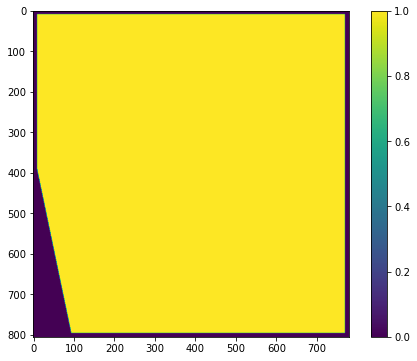

In [44]:
#plotting the masks used
plt.imshow((mask_tri))
plt.colorbar()
plt.show()

## 1D Azimuthal Intergration Sanity check and mask checks

In [45]:
quad_to_look_at = 3

Text(0.5, 1.0, 'Run 600 Quad3')

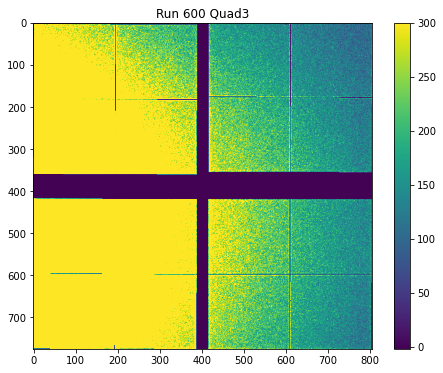

In [46]:
#plotting the quads we want. 
Run = Runs[1]
quad_2_plot = quad_to_look_at
plt.imshow(Run_images['Run ' +str(Run)] ['Quad' + str(quad_2_plot)]-dark_run_images['Run 124']['Quad3'], vmax = 300)
plt.colorbar()
plt.title('Run ' +str(Run) + ' Quad' + str(quad_2_plot))


In [47]:
Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[quad_to_look_at])]

array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,  41.529274,  76.321335,
         93.51043 ],
       [  0.      ,   0.      ,   0.      , ...,  54.01957 ,  53.42464 ,
        101.548164],
       ...,
       [477.6593  , 388.16888 , 306.88452 , ..., 107.98091 ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ..., 128.87518 ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,  59.708714,   0.      ,
          0.      ]], dtype=float32)

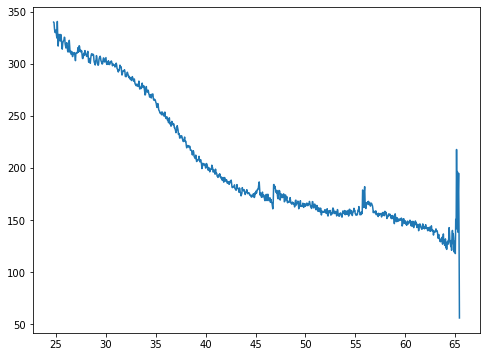

In [48]:
## Azimuthal integration
# mask_1 = images!=0.0 # masks out the low pixels(=0) (areas between the modules)


mask_1 = Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[quad_to_look_at])]!=0.0 # masks out the low pixels(=0) (areas between the modules) here we care about the c values or the intensity
mask_2 = Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[quad_to_look_at])]<500 ## masks out the hot pixels (>500) (areas between the modules)

# x = np.linspace(0, 100, 100)
# mask_3 = images<line_mask(x)

edge_mask_width = 10
mask_edge = np.full(np.shape(Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[quad_to_look_at])]), True)
mask_edge[0:edge_mask_width, :] = False
mask_edge[-edge_mask_width:-1, :] = False
mask_edge[:, 0:edge_mask_width] = False
mask_edge[:, -edge_mask_width:-1] = False

if quad_to_look_at == 0:
    mask = mask_1 & mask_2 & mask_tri & mask_edge
else:
    mask = mask_1 & mask_2 & mask_edge
    
    
mask = mask.astype('float')

mask[mask == 0] = np.nan #mask is  a nanmaks ie nans and ones

mask_zeros = mask
mask_zeros[mask == np.nan] = 0 

dark = dark_run_images['Run 124'] ["Quad"+str(quad_to_look_at)]

Integ_results = calib_all['Calib Quad'+str(quad_to_look_at)].integrate1d(Run_images['Run ' + str(Runs[0])]['Quad'+ str(Quads[quad_to_look_at])]*mask-dark, 1000, unit= "2th_deg")

x = Integ_results[0]
y = Integ_results[1]
y[y == 0] = np.nan

plt.plot(x, y)

In [49]:
np.shape(mask_tri)

(806, 779)

## Masking between the modules check

(806, 779)

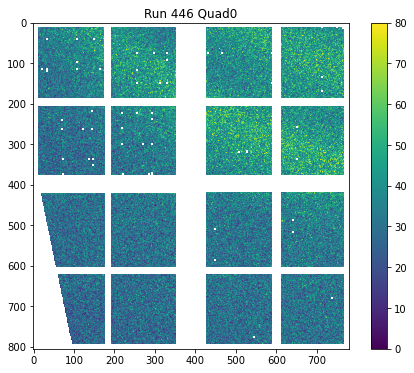

In [50]:
Run = Runs[0]
quad_2_plot = 0
test = Run_images['Run ' +str(Run)] ['Quad' + str(quad_2_plot)]
mask_moduleedge = np.full(np.shape(test), True)
# mask_moduleedge[:, 180:190] = False
# mask_moduleedge[190:205, :] = False
# mask_moduleedge[:, 590:610] = False    # areas which are false are zeros and true is one. 
# mask_moduleedge[605:620, :] = False
# mask_moduleedge[380:400, :] = False
# mask_moduleedge[:, 355:425] = False
mask_moduleedge[:, 180:190] = False
mask_moduleedge[190:205, :] = False
mask_moduleedge[:, 590:610] = False    # areas which are false are zeros and true is one. 
mask_moduleedge[605:620, :] = False
mask_moduleedge[380:400, :] = False
mask_moduleedge[:, 355:425] = False

# mask_moduleedge[:, 180:200] = False
# mask_moduleedge[175:190, :] = False
# mask_moduleedge[:, 600:620] = False    # areas which are false are zeros and true is one. 
# mask_moduleedge[585:600, :] = False
# mask_moduleedge[350:360, :] = False
# mask_moduleedge[:, 375:385] = False

mask_1 = test != 0.0 # masks out the low pixels(<1) (areas between the modules) (i.e these values are true)
mask_2 = test < 500 ## masks out the hot pixels (>500) (areas between the modules)(i.e these values are true)
mask_edge = np.full(np.shape(test), True)
mask_edge[0:edge_mask_width, :] = False
mask_edge[-edge_mask_width:-1, :] = False
mask_edge[:, 0:edge_mask_width] = False    # areas which are false are zeros and true is one. 
mask_edge[:, -edge_mask_width:-1] = False


mask_moduleedge = mask_moduleedge.astype('float')
mask_moduleedge[mask_moduleedge==0] = np.nan

masknew =mask_1*mask_2*mask_edge*mask_moduleedge* mask_tri
#masknew = mask_1 & mask_2 & mask_edge & mask_moduleedge & mask_tri
masknew = masknew.astype('float')
masknew[masknew==0] =  np.nan

plt.imshow(test*masknew, vmin= 0, vmax=80)
plt.colorbar()
plt.title('Run ' +str(Run) + ' Quad' + str(quad_2_plot))

np.shape(test)

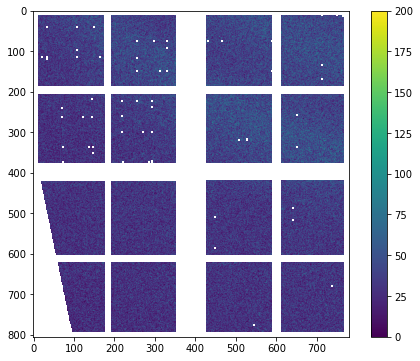

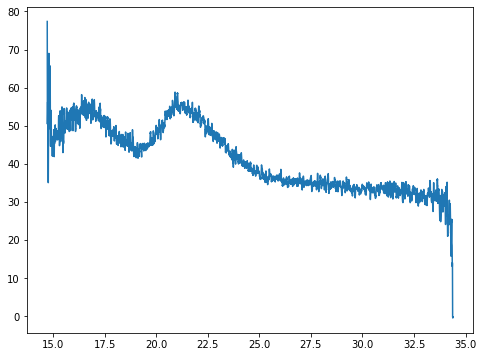

In [51]:

plt.figure()
plt.imshow(test*masknew)
plt.clim(0,200)
plt.colorbar()
#plt.title('Run ' +str(Run) + ' Quad' + str(quad_2_plot))

plt.figure()
Integ_results = calib_all['Calib Quad'+str(quad_2_plot)].integrate1d(test*masknew, npt = 5000, correctSolidAngle = True, unit= "2th_deg")
x = Integ_results[0]
y = Integ_results[1]
y[y == 0] = np.nan
plt.plot(x, y)
#plt.title('Run ' +str(Run) + ' Quad' + str(quad_2_plot))

In [52]:

quad_2_plot = 3
calib_all['Calib Quad'+str(quad_2_plot)]

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 7.290000e-11m
SampleDetDist= 1.019933e-01m	PONI= 5.014607e-02, 5.434908e-03m	rot1=0.475808  rot2= -0.002768  rot3= 0.000005 rad
DirectBeamDist= 114.739mm	Center: x=-471.217, y=498.285 pix	Tilt=27.262 deg  tiltPlanRotation= -179.654 deg

# 1D Azimuthal Intergration

In [53]:
## Azimuthal integration
Int_keys = []
Int_quad_keys = []
for j in Runs:
   keys = 'Run ' + str((j))
   Int_keys.append(keys)
Int_1D_results = dict.fromkeys(Int_keys) 

for i in Quads:
   keys = 'Quad' + str((i))
   Int_quad_keys.append(keys)

counter = 0
   
for j in Runs:
   Int_1D_quads = dict.fromkeys(Int_quad_keys)
   for i in Quads:
      img = Run_images['Run ' + str(j)]['Quad'+ str(i)]
      mask_1 = Run_images['Run ' + str(j)]['Quad'+ str(i)] != 0.0 # masks out the low pixels(<1) (areas between the modules) (i.e these values are true)
      mask_2 = Run_images['Run ' + str(j)]['Quad'+ str(i)] < 500 ## masks out the hot pixels (>500) (areas between the modules)(i.e these values are true)
      mask_moduleedge0 = np.full(np.shape(img), True)
      mask_moduleedge0[:, 180:190] = False
      mask_moduleedge0[190:205, :] = False
      mask_moduleedge0[:, 590:610] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge0[605:620, :] = False
      mask_moduleedge0[380:400, :] = False
      mask_moduleedge0[:, 355:425] = False
      
      mask_moduleedge1 = np.full(np.shape(img), True)
      mask_moduleedge1[:, 180:200] = False
      mask_moduleedge1[175:190, :] = False
      mask_moduleedge1[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge1[585:600, :] = False
      mask_moduleedge1[350:360, :] = False
      mask_moduleedge1[:, 385:420] = False
      
      mask_moduleedge2 = np.full(np.shape(img), True)
      mask_moduleedge2[:, 180:200] = False
      mask_moduleedge2[175:190, :] = False
      mask_moduleedge2[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge2[585:600, :] = False
      mask_moduleedge2[400:420, :] = False
      mask_moduleedge2[:, 385:420] = False
      
      mask_moduleedge3 = np.full(np.shape(img), True)
      mask_moduleedge3[:, 180:200] = False
      mask_moduleedge3[175:190, :] = False
      mask_moduleedge3[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge3[585:600, :] = False
      mask_moduleedge3[350:360, :] = False
      mask_moduleedge3[:, 375:385] = False
      
      mask_edge = np.full(np.shape(img), True)
      mask_edge[0:edge_mask_width, :] = False
      mask_edge[-edge_mask_width:-1, :] = False
      mask_edge[:, 0:edge_mask_width] = False    # areas which are false are zeros and true is one. Actually as true or false its a boolean 
      mask_edge[:, -edge_mask_width:-1] = False
      
      if i == 0:
         mask = mask_1 & mask_2 & mask_tri & mask_edge & mask_moduleedge0
      elif i == 1:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge1
      elif i == 2:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge2
      elif i == 3:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge3
         
      mask = mask.astype('float')
      mask[mask == 0] = np.nan
      calib_all['Calib Quad' + str(i)].wavelength = lams[counter]
      
      dark = dark_run_images['Run 124'] ["Quad"+ str(i)]
      
      Integ_results = calib_all['Calib Quad' + str(i)].integrate1d(img*mask-dark, 5000, unit="2th_deg") # remember to put bin correctSolidAngle = False
      Integ_results[1][Integ_results[1] == 0] = np.nan
       
      Int_1D_quads['Quad' + str((i))] =  Integ_results
   Int_1D_results['Run ' + str((j))] = Int_1D_quads
   counter = counter + 1
      
#print(Int_1D_results)

In [54]:
# for count, _ in enumerate(Runs):
#     print(count)
density_of_points = 80


nbin_run = dict.fromkeys(Run_key_list) 
Range_per_run = dict.fromkeys(Run_key_list)
max_run = dict.fromkeys(Run_key_list)
min_run = dict.fromkeys(Run_key_list)
for j, _ in enumerate(Runs):
   nbin_quads = dict.fromkeys(Quad_key_list)
   range_quads = dict.fromkeys(Quad_key_list)
   max_quad = dict.fromkeys(Quad_key_list)
   min_quad = dict.fromkeys(Quad_key_list)
   for i, _ in enumerate(Quads):
      x = Int_1D_results['Run ' + str(Runs[j])]['Quad' + str(i)][0]
      np.max
      print('shape:', np.shape(x))
      print('max: ', np.max(x))
      print('min: ', np.min(x))
      range = np.max(x) - np.min(x)
      print('range: ', range)
      nbins = np.around(range* density_of_points,0)
      nbin_quads['Quad' + str((i))] = nbins
      #print('density: ', density)
      range_quads['Quad' + str((i))] =  range
      max_quad['Quad' + str((i))] = np.max(x)
      min_quad['Quad' + str((i))] = np.min(x)
   
   nbin_run['Run ' + str(Runs[j])] = nbin_quads
   Range_per_run['Run ' + str(Runs[j])] = range_quads
   max_run['Run ' + str(Runs[j])] = max_quad
   min_run['Run ' + str(Runs[j])] = min_quad
      


shape: (5000,)
max:  35.36610214807028
min:  14.473124246225177
range:  20.892977901845107
shape: (5000,)
max:  28.448403451602694
min:  9.28994136965034
range:  19.158462081952354
shape: (5000,)
max:  71.43780559655599
min:  41.928539601982635
range:  29.509265994573354
shape: (5000,)
max:  65.49417758819608
min:  24.215576064996597
range:  41.278601523199484
shape: (5000,)
max:  35.36610214807028
min:  14.473124246225177
range:  20.892977901845107
shape: (5000,)
max:  28.448403451602694
min:  9.28994136965034
range:  19.158462081952354
shape: (5000,)
max:  71.43780559655599
min:  41.928539601982635
range:  29.509265994573354
shape: (5000,)
max:  65.49417758819608
min:  24.215576064996597
range:  41.278601523199484
shape: (5000,)
max:  35.36610214807028
min:  14.473124246225177
range:  20.892977901845107
shape: (5000,)
max:  28.448403451602694
min:  9.28994136965034
range:  19.158462081952354
shape: (5000,)
max:  71.43780559655599
min:  41.928539601982635
range:  29.509265994573354
sh

In [55]:
# for j, _ eni
# min_run['Run ' + str(Runs[j])]['Quad' + str((i))]

## 1D integration with specific bin numbers (get the same nbins per degree)

In [56]:
## Azimuthal integration
Int_keys = []
Int_quad_keys = []
for j in Runs:
   keys = 'Run ' + str((j))
   Int_keys.append(keys)
Int_1D_results = dict.fromkeys(Int_keys) 

for i in Quads:
   keys = 'Quad' + str((i))
   Int_quad_keys.append(keys)

counter = 0
   
for j in Runs:
   Int_1D_quads = dict.fromkeys(Int_quad_keys)
   for i in Quads:
      img = Run_images['Run ' + str(j)]['Quad'+ str(i)]
      mask_1 = Run_images['Run ' + str(j)]['Quad'+ str(i)] != 0.0 # masks out the low pixels(<1) (areas between the modules) (i.e these values are true)
      mask_2 = Run_images['Run ' + str(j)]['Quad'+ str(i)] < 500 ## masks out the hot pixels (>500) (areas between the modules)(i.e these values are true)
      mask_moduleedge0 = np.full(np.shape(img), True)
      mask_moduleedge0[:, 180:190] = False
      mask_moduleedge0[190:205, :] = False
      mask_moduleedge0[:, 590:610] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge0[605:620, :] = False
      mask_moduleedge0[380:400, :] = False
      mask_moduleedge0[:, 355:425] = False
      
      mask_moduleedge1 = np.full(np.shape(img), True)
      mask_moduleedge1[:, 180:200] = False
      mask_moduleedge1[175:190, :] = False
      mask_moduleedge1[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge1[585:600, :] = False
      mask_moduleedge1[350:360, :] = False
      mask_moduleedge1[:, 385:420] = False
      
      mask_moduleedge2 = np.full(np.shape(img), True)
      mask_moduleedge2[:, 180:200] = False
      mask_moduleedge2[175:190, :] = False
      mask_moduleedge2[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge2[585:600, :] = False
      mask_moduleedge2[400:420, :] = False
      mask_moduleedge2[:, 385:420] = False
      
      mask_moduleedge3 = np.full(np.shape(img), True)
      mask_moduleedge3[:, 180:200] = False
      mask_moduleedge3[175:190, :] = False
      mask_moduleedge3[:, 600:620] = False    # areas which are false are zeros and true is one. 
      mask_moduleedge3[585:600, :] = False
      mask_moduleedge3[350:360, :] = False
      mask_moduleedge3[:, 375:385] = False
      
      mask_edge = np.full(np.shape(img), True)
      mask_edge[0:edge_mask_width, :] = False
      mask_edge[-edge_mask_width:-1, :] = False
      mask_edge[:, 0:edge_mask_width] = False    # areas which are false are zeros and true is one. Actually as true or false its a boolean 
      mask_edge[:, -edge_mask_width:-1] = False
      
      if i == 0:
         mask = mask_1 & mask_2 & mask_tri & mask_edge & mask_moduleedge0
      elif i == 1:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge1
      elif i == 2:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge2
      elif i == 3:
         mask = mask_1 & mask_2 & mask_edge & mask_moduleedge3
         
      mask = mask.astype('float')
      mask[mask == 0] = np.nan
      calib_all['Calib Quad' + str(i)].wavelength = lams[counter]
      
      dark = dark_run_images['Run 124'] ["Quad"+ str(i)]
      
      Integ_results = calib_all['Calib Quad' + str(i)].integrate1d(img*mask-dark, npt = (nbin_run['Run ' + str(j)]['Quad'+ str(i)]) ,  unit="2th_deg") # remember to put bin correctSolidAngle = False
      Integ_results[1][Integ_results[1] == 0] = np.nan
       
      Int_1D_quads['Quad' + str((i))] =  Integ_results
   Int_1D_results['Run ' + str((j))] = Int_1D_quads
   counter = counter + 1
      
#print(Int_1D_results)

## Resample the data


In [57]:
j = 0
i = 0
## create new x and y data
minimum = np.ceil(min_run['Run ' + str(Runs[j])]['Quad' + str((i))])
maximum = np.floor(max_run['Run ' + str(Runs[j])]['Quad' + str((i))])
number = maximum - minimum
npt = int(number * density_of_points)
x0_new = np.linspace(minimum, maximum, num = npt, endpoint=True, retstep=False, dtype=None, axis=0)
#y0_new


Text(0.5, 1.0, 'Run 446 Quad0 before resampling')

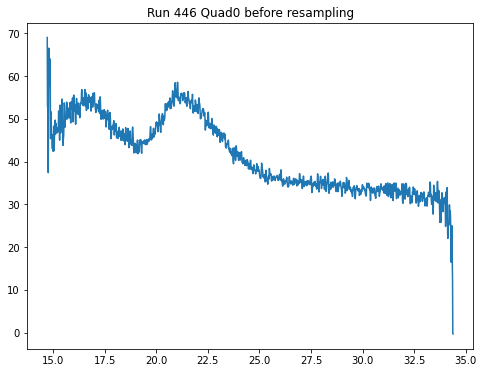

In [58]:
j = 0
i = 0
x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]


plt.plot(x,y)
plt.title ('Run ' +str(Runs[i]) + ' Quad' + str(j) + ' before resampling' )

In [59]:
max_run

{'Run 446': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 600': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 612': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 615': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 606': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 609': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608},
 'Run 603': {'Quad0': 35.36610214807028,
  'Quad1': 28.448403451602694,
  'Quad2': 71.43780559655599,
  'Quad3': 65.49417758819608}}

In [60]:
# Do I use pandas to resample the data?

In [61]:
# print(35.2-14.6)
# print (1671/20.9)
# print (6*13)

# print(28.2-9.4)
# print (1671/20.9)
# print (6*13)

#print(71.2-42.1)
# print (1671/20.9)
# print (6*13)

print(65.2-24.4)
# print (1671/20.9)
# print (6*13)

# print(nbin_run)

40.800000000000004


## Saving the files

In [62]:

# for i in range(len(Runs)): 
#     for j in Quads:
#         x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
#         y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
#         np.savetxt('XRun ' + str(Runs[i])+ ' Quad' + str(j), x, delimiter=",")
#         np.savetxt('YRun ' + str(Runs[i])+ ' Quad' + str(j), y, delimiter=",")
        
# os.getcwd()

## Plotting all the Runs

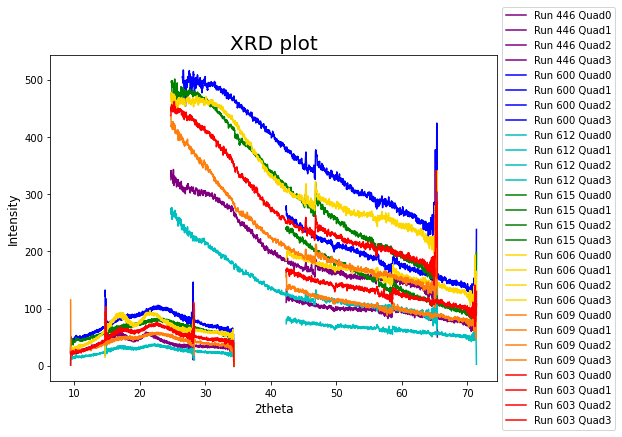

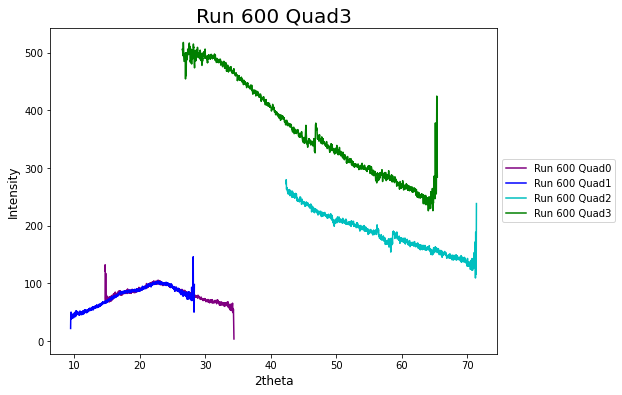

In [63]:
# plotting intergrated results for any Run and all quads
clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple']#, 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
plt.figure()
for i, _ in enumerate(Runs):
    for j, _ in enumerate(Quads):
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[i]) 
    
plt.xlabel('2theta', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
i =1
for j, _ in enumerate(Quads):
    x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
    y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
    plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[j]) 
    
plt.xlabel('2theta', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('Run ' +str(Runs[i])+' Quad' + str(j), fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# max(Integresults[1])

# Peak fitting

In [64]:
#fitting a gaussian fit? How does one fit a curve? 
#step 1: Define a peak fitting function. This can be any function you want, just write down the function with all the defining parameters. Pro tip: Plot the function on desmos and see how each fitting parameter affects the curve fit to understand your function better

def gaussfit(x, B, a, x0, sigma):
    return B + a*np.exp(-(x-x0)**2/(2*sigma**2))

def twogaussfit(x, B, a0, x0, sigma0, a1, x1, sigma1):
    return B + a0*np.exp(-(x-x0)**2/(2*sigma0**2))+a1*np.exp(-(x-x1)**2/(2*sigma1**2))

def threegaussfit(x, B, a0, x0, sigma0, a1, x1, sigma1, a2, x2, sigma2):
    return B + a0*np.exp(-(x-x0)**2/(2*sigma0**2))+a1*np.exp(-(x-x1)**2/(2*sigma1**2))+a2*np.exp(-(x-x2)**2/(2*sigma2**2))

def fourgaussfit(x, B, a0, x0, sigma0, a1, x1, sigma1, a2, x2, sigma2, a3, x3, sigma3):
    return B + a0*np.exp(-(x-x0)**2/(2*sigma0**2))+a1*np.exp(-(x-x1)**2/(2*sigma1**2))+a2*np.exp(-(x-x2)**2/(2*sigma2**2))+a3*np.exp(-(x-x3)**2/(2*sigma3**2))

def twolorenfit(x, B, a0, x0, sigma0, a1, x1, sigma1):
    return B + (a0/(((x-x0)/sigma0)**2+1))**2 + (a1/(((x-x1)/sigma1)**2+1))**2
#i = 0
# Quad 0

## Two gaussian fit

In [65]:
#                  B,    a0,    x0,    sigma0,    a1,    x1, sigma1
# p0 =     np.array([6,    20,    16,        1,     10,    21,     2])
# B_low =  np.array([0,    0,     10,         0,    0,     15,     0])
# B_high = np.array([10,    50,    19,         3,    10,    22,     3])
# Bounds = (B_low,B_high)


p0 =     np.array([35,    50,     30,      10,     15,    60,     50])#,    20,     55,     9])#,   30,   47,   1])
B_low =  np.array([25,     0,     20,      0,     0,     40,      0])#,     0,      40,     0])#,   10,   47,   0])
B_high = np.array([80,    100,    32,      50,    50,    70,     100])#,    50,     70,     20])#,  50,   51,   3])
Bounds = (B_low,B_high)

combined_list = [item for triplet in zip(B_low, p0, B_high) for item in triplet]
print(combined_list)

[25, 35, 80, 0, 50, 100, 20, 30, 32, 0, 10, 50, 0, 15, 50, 40, 60, 70, 0, 50, 100]


[ 25.         100.          20.          43.10713388   0.62502293
  40.04410651  39.24148306]
error: [   3509.9159942   229436.50799268   40458.79632321   10413.32524462
  243138.8842144  2945459.64081433  833801.77718905]


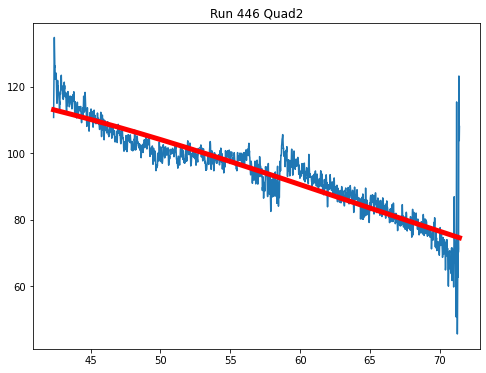

In [66]:
i = 0
quad_2_plot = 2
x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(twogaussfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
std_fit = np.sqrt(np.diag(pcov))
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0],Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(quad_2_plot) ][1])
plt.plot(x[valid], twogaussfit(x[valid], *popt),color = 'r',linewidth = 5)
plt.title('Run ' +str(Runs[i]) + ' Quad' + str(quad_2_plot))
print("error:", std_fit)

#chisqr, p_value = chisquare(y[valid], f_exp = twogaussfit(x[valid], *popt ))

# print("Chi-square:", chisqr) #why is it nan?
# print("P-value:", p_value)

plt.show()

## Two lorentzian fit

In [67]:
#                  B,    a0,    x0,    sigma0,    a1,    x1, sigma1
p0 =     np.array([6,    20,    16,        1,     10,    21,     2])
B_low =  np.array([0,    0,     10,         0,    0,     15,     0])
B_high = np.array([10,    50,    19,         3,    10,    22,     3])
Bounds = (B_low,B_high)

[10.          9.35584847 16.34680386  3.         10.         22.
  3.        ]


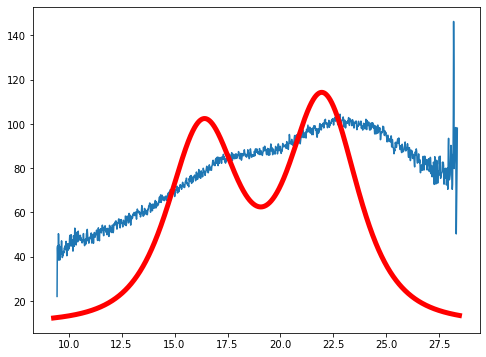

In [68]:
i = 1
x = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(twolorenfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad1' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], twolorenfit(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], *popt),color = 'r',linewidth = 5)
plt.show()

In [69]:
#                  B,    a0,    x0,    sigma0,    a1,    x1, sigma1
p0 =     np.array([6,    20,    16,        1,     10,    21,     2])
B_low =  np.array([0,    0,     10,         0,    0,     15,     0])
B_high = np.array([10,    50,    19,         3,    10,    22,     3])
Bounds = (B_low,B_high)

[10.          4.83789957 16.62170154  3.          5.62842846 22.
  3.        ]


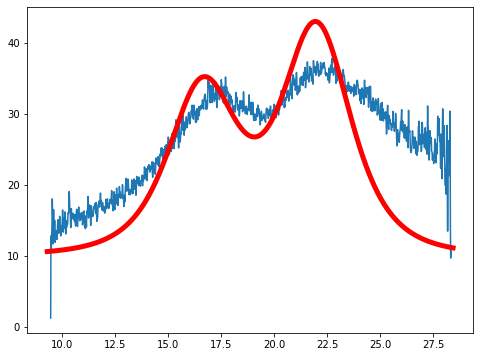

In [70]:
i = 2
x = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][1]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(twolorenfit, x[valid],y[valid], p0, bounds = Bounds)
print(popt)
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0],Int_1D_results['Run ' +str(Runs[i])]['Quad1' ][1])
plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], twolorenfit(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0], *popt),color = 'r',linewidth = 5)
plt.show()

In [71]:
# #                  B,    a0,    x0,    sigma0,    a1,    x1, sigma1,    a1,    x1, sigma1
# p0 =     np.array([6,    20,    15,        1,     10,    21,     2,     2,     18,     10])
# B_low =  np.array([0,    0,     10,        0,      0,    15,     0,     0,     15,     0])
# B_high = np.array([10,    50,    20,       3,     10,    22,     3,    10,     25,     20])
# Bounds = (B_low,B_high)

## Three gaussian fit

In [72]:
# # #                  B,    a0,    x0,    sigma0,    a1,    x1, sigma1,    a1,    x1, sigma1
# p0 =     np.array([15,    55,    11.5,        1,     60,    19,   0.5,    2,     18,    10])
# B_low =  np.array([0,     0,     11.5,        0,      0,    18,     0,     0,     15,     0])
# B_high = np.array([50,    80,    18,        2,       70,    21,     1,    10,     25,     20])
# Bounds = (B_High,B_high)

 #                 B,    a0,    x0,    sigma0,   a1,    x1, sigma1,    a1,    x1, sigma1
# p0 =     np.array([6,     20,    20,      1,     15,    26,     2,     2,     11,     10])
# B_low =  np.array([0,     0,     20,      0,     0,     20,     0,     0,     10,     0])
# B_high = np.array([10,    50,    25,      3,     20,    30,     3,    10,     20,     20])
# Bounds = (B_low,B_high)

In [73]:
 #                 B,    a0,    x0,    sigma0,   a1,    x1, sigma1,    a1,    x1,  sigma1
p0 =     np.array([7,     20,    17,      2,     15,    21,     2,     20,     29,     9])
B_low =  np.array([5,     0,     16,      0,     0,     19,     0,     0,      20,     0])
B_high = np.array([10,    50,    25,      5,     20,    30,     5,     50,     32,     20])
Bounds = (B_low,B_high)

In [74]:
 #                 B,    a0,    x0,    sigma0,   a1,    x1, sigma1,    a2,    x2,  sigma2   a3,   x3,  sigma3
# p0 =     np.array([10,    20,    29,      9,     15,    45,     3,     20,     55,     9,   30,   47,   1])
# B_low =  np.array([5,     0,     20,      0,     0,     40,     0,     0,      40,     0,   10,   47,   0])
# B_high = np.array([20,    80,    32,      20,    20,    60,     10,    50,     70,     20,  50,   51,   3])
# Bounds = (B_low,B_high)

#  #                 B,    a0,    x0,    sigma0,   a1,    x1, sigma1,    a2,    x2,  sigma2   a3,   x3,  sigma3
# p0 =     np.array([50,    20,    29,      9,     15,    60,     10,    20,     55,     9])#,   30,   47,   1])
# B_low =  np.array([30,     0,     22,      0,     0,     40,     0,     0,      40,     0])#,   10,   47,   0])
# B_high = np.array([60,    100,    32,      10,    20,    70,     30,    50,     70,     20])#,  50,   51,   3])
# Bounds = (B_low,B_high)

                #  B,    a0,    x0,    sigma0,   a1,    x1, sigma1,    a2,    x2,  sigma2
p0 =     np.array([10,    20,    17,        1,     15,    20,     2,     10,     27,     2])
B_low =  np.array([9.5,    0,    12,        0,     0,     18,     0,     0,      25,     0])
B_high = np.array([25,    50,    20,        5,     20,    22.5,   5,     50,     35,    20])
Bounds = (B_low,B_high)




[ 9.5        24.44174226 16.45681339  1.99288083 19.8361637  21.69731262
  1.48368382 24.61974248 25.         14.86978697]
[22.08550499  0.76144994  0.02732804  0.0531699   0.56511053  0.02853196
  0.03973406 21.98472331  1.22358646  8.89407076]


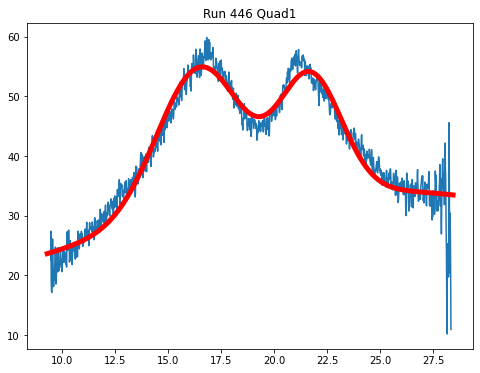

In [75]:
#Runs = [140, 141, 144, 147, 150, 153, 158, 161, 164]
i = 0
quad_2_plot = 1
x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0]
y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][1]
# x = x [50:-100]
# y = y [50:-100]
valid = ~(np.isnan(x)|np.isnan(y))
popt, pcov = curve_fit(threegaussfit, x[valid],y[valid], p0, bounds = Bounds)
std_fit = np.sqrt(np.diag(pcov)) #Ahmed gave me this line. Rahul also has the same line he got from Ezio.
print(popt)

#pcov is a fucking jacobian matrix which consists of partial derivative of the gaussian function wrt to all the parameters(variables). Higher slope, higher derivatives. Higher the slope, higher the uncertainity (cos if you change the parameters by a small amount the function is changing a lot). Diagonal p cov are the unique ones? I am not sure, I will need to write down and check but moving on. 


#popt, pcov = curve_fit(fourgaussfit, x[valid],y[valid], p0, bounds = Bounds)

#plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0],Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(quad_2_plot) ][1])
plt.plot(x,y)

plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0], threegaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0], *popt),color = 'r',linewidth = 5)

#plt.plot(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0], fourgaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(quad_2_plot)][0], *popt),color = 'r',linewidth = 5)
#np.savetxt('Run ' + str(Runs[i])+ ' Quad' + str(j), threegaussfit(Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0]), delimiter=",")
plt.title('Run ' +str(Runs[i]) + ' Quad' + str(quad_2_plot))
#plt.ylim(0, 30)
print(std_fit) #error

# chisqr, p_value = chisquare(y[valid], f_exp = threegaussfit(x[valid], *popt ))

# print("Chi-square:", chisqr) #why is it nan?
# print("P-value:", p_value)
plt.show()


# Add the chi square and see what fit gives you the lowest value. Also do lm fit.chop off the end artifacts. 

##  Saving the fit parameters

In [76]:
###Uggghhhhhh I have to do this. Come one Meera. Lets do this is thaaaaaanggggg.....meow meow meow meow

# name_savedfile = results_save_dir +  'Run ' + str(Runs[i]) + ' Quad' + str(quad_2_plot) +'fit' + '.csv'

# fluence_vs_params_A0 = np.empty([nb_file_BG, 22], dtype = np.float32)

# fluence_vs_params_A0[:, 0] = A_A0
# fluence_vs_params_A0[:, 1] = dA_A0

# fluence_vs_params_A0[:, 2] = B_A0
# fluence_vs_params_A0[:, 3] = dB_A0

# fluence_vs_params_A0[:, 4] = C_A0
# fluence_vs_params_A0[:, 5] = dC_A0

# fluence_vs_params_A0[:, 6] = t_0_A0
# fluence_vs_params_A0[:, 7] = dt_0_A0

# fluence_vs_params_A0[:, 8] = t_m_A0
# fluence_vs_params_A0[:, 9] = dt_m_A0

# fluence_vs_params_A0[:, 10] = t_r_A0
# fluence_vs_params_A0[:, 11] = dt_r_A0

# fluence_vs_params_A0[:, 12] = A_1_A0
# fluence_vs_params_A0[:, 13] = dA_1_A0

# fluence_vs_params_A0[:, 14] = A_2_A0
# fluence_vs_params_A0[:, 15] = dA_2_A0

# fluence_vs_params_A0[:, 16] = A_q_A0
# fluence_vs_params_A0[:, 17] = dA_q_A0

# fluence_vs_params_A0[:, 18] = t_min_A0
# fluence_vs_params_A0[:, 19] = dt_min_A0

# fluence_vs_params_A0[:, 20] = sigma_A0
# fluence_vs_params_A0[:, 21] = dsigma_A0

# column_labels = ['A', 'dA', 'B', 'dB', 'C', 'dC', 't_0', 'dt_0', 't_m', 'dt_m', 't_r', 'dt_r', 'A_1', 'dA_1', 'A_2', 'dA_2', 'A_q', 'dA_q', 't_min', 'dt_min', 'sigma', 'dsigma']

# df2 = pd.DataFrame(fluence_vs_params_A0, columns=column_labels, index=fluence_list)
# df2.to_pickle(file_2)

## Fitting all runs (automated)

## Importing the fit guess and bounds

In [243]:

Quad0_fit_bounds_params = pd.read_excel(fit_params_file, sheet_name='Quad0')
Quad1_fit_bounds_params = pd.read_excel(fit_params_file, sheet_name='Quad1')
Quad2_fit_bounds_params = pd.read_excel(fit_params_file, sheet_name='Quad2')
Quad3_fit_bounds_params = pd.read_excel(fit_params_file, sheet_name='Quad3')

## Peak fitting

In [244]:
# for i in range(len(Runs)):
#     run_num = Runs[i]
#     print(run_num)

In [245]:
Runs[0]

446

In [246]:
run_num = Runs[1]
p0, Bounds = mfc.get_fit_guess(Quad0_fit_bounds_params, run_num, 3)
print(p0, Bounds)

[10.  20.  18.5  1.  15.  20.   2.  10.  27.   2. ] (array([ 9.5,  0. , 17. ,  0. ,  0. , 18. ,  0. ,  0. , 25. ,  0. ]), array([60. , 50. , 19. ,  3.5, 20. , 24. ,  5. , 50. , 35. , 20. ]))


In [247]:

fit_results_byruns = dict.fromkeys(Run_key_list) 

for i, _ in enumerate(Runs):
    run_num = Runs[i]
    fit_results_byquads = dict.fromkeys(Quad_key_list)
    for j, _ in enumerate(Quads):
        if j == 0:
            p0, Bounds = mfc.get_fit_guess(Quad0_fit_bounds_params, run_num, 3)
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
            valid = ~(np.isnan(x)|np.isnan(y))
            popt0, pcov0 = curve_fit(threegaussfit, x[valid],y[valid], p0, bounds = Bounds)
            err_fit0 = np.sqrt(np.diag(pcov0))
            fit_param0 = [popt0, err_fit0]
            fit_results_byquads['Quad' + str((j))] = fit_param0
        elif j == 1:
            p0, Bounds = mfc.get_fit_guess(Quad1_fit_bounds_params, run_num, 3)
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
            valid = ~(np.isnan(x)|np.isnan(y))
            popt1, pcov1 = curve_fit(threegaussfit, x[valid],y[valid], p0, bounds = Bounds)
            err_fit1 = np.sqrt(np.diag(pcov1))
            fit_param1 = [popt1, err_fit1]
            fit_results_byquads['Quad' + str((j))] = fit_param1
        elif j == 2:
            p0, Bounds = mfc.get_fit_guess(Quad2_fit_bounds_params, run_num, 2)
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
            valid = ~(np.isnan(x)|np.isnan(y))
            popt2, pcov2 = curve_fit(twogaussfit, x[valid],y[valid], p0, bounds = Bounds)
            err_fit2 = np.sqrt(np.diag(pcov2))
            fit_param2 = [popt2, err_fit2]
            fit_results_byquads['Quad' + str((j))] = fit_param2
        elif j == 3:
            p0, Bounds = mfc.get_fit_guess(Quad3_fit_bounds_params, run_num, 2)
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
            valid = ~(np.isnan(x)|np.isnan(y))
            popt3, pcov3 = curve_fit(twogaussfit, x[valid],y[valid], p0, bounds = Bounds)
            err_fit3 = np.sqrt(np.diag(pcov3))
            fit_param3 = [popt3, err_fit3]
            fit_results_byquads['Quad' + str((j))] = fit_param3
    fit_results_byruns['Run ' + str(Runs[i])] = fit_results_byquads

## Plotting fits

In [248]:
i = 0
j = 2
fit_results_byruns['Run ' + str(Runs[i])]['Quad' + str(j)][0]

array([ 51.42435944, 153.50525847,  26.76758501,  10.2794749 ,
        42.85633819,  56.39061722,  11.99100924])

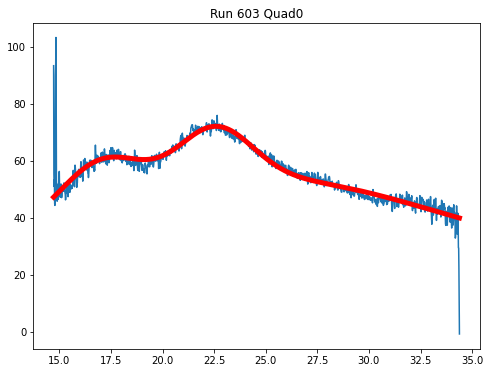

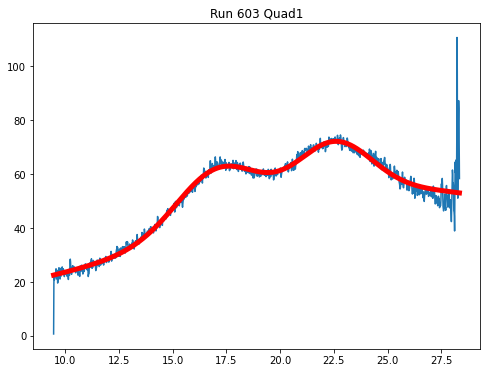

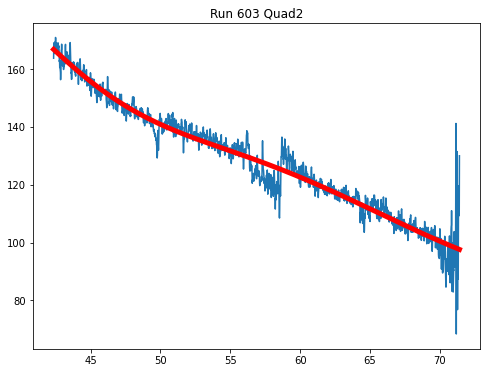

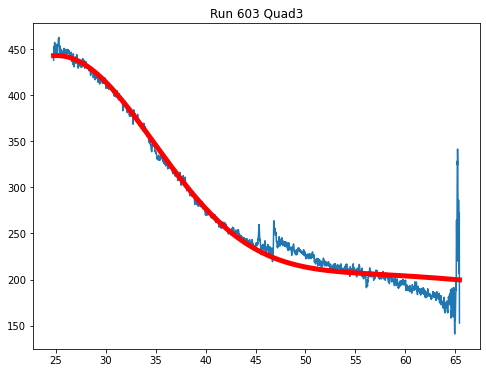

Fit param Run 603 Quad0: [25.         17.56129247 17.          2.         19.44479258 22.5
  1.79476046 28.51936443 25.          8.23534055]
Fit param Run 603 Quad1: [ 9.5        21.36031089 17.06898141  1.9165917  20.         22.47867146
  1.73917445 44.57583913 25.96665402 10.53337239]
Fit param Run 603 Quad2: [78.98154142 99.99999992 31.94365329  8.91246017 50.         52.61130916
 13.37811888]
Fit param Run 603 Quad3: [184.36595558 257.54213421  25.          10.          20.
  56.          12.74191462]
Fit error Run 603 Quad0: [22.15724968 10.39142474  0.121887    0.48757334  4.30378811  0.09182016
  0.10716318 23.83233027  2.50066348  6.00002241]
Fit error Run 603 Quad1: [6.19449666 1.21433387 0.04438581 0.07233375 1.70081168 0.04302334
 0.09466747 5.68190254 1.0996666  1.91650328]
Fit error Run 603 Quad2: [13.35952387 82.12882137  7.16849399  4.89736383 26.44471276  7.63445125
  6.48037008]
Fit error Run 603 Quad3: [56.32277781 45.28066564  0.43732175  0.33108296 55.68081618  2.5

In [249]:
i = 6
Run_to_plot = Runs[i]

for j, _ in enumerate(Quads):
    if j == 0:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
        valid = ~(np.isnan(x)|np.isnan(y))
        plt.plot(x[valid], y[valid])
        plt.plot(x[valid], threegaussfit(x[valid], *fit_results_byruns['Run ' + str(Runs[i])]['Quad' + str(j)][0]),color = 'r',linewidth = 5)
        plt.title('Run ' + str(Runs[i])+ ' Quad'+  str(j))
        # print(fit_param0)
        # print(popt0)
        # print(err_fit0)
        plt.show()
        
    
    elif j == 1:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
        valid = ~(np.isnan(x)|np.isnan(y))
        plt.plot(x[valid], y[valid])
        plt.plot(x[valid], threegaussfit(x[valid], *fit_results_byruns['Run ' + str(Runs[i])]['Quad' + str(j)][0]),color = 'r',linewidth = 5)
        plt.title('Run ' + str(Runs[i])+ ' Quad'+  str(j))
        # print(popt1)
        # print(err_fit1)
        plt.show()
        
    elif j == 2:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
        valid = ~(np.isnan(x)|np.isnan(y))
        plt.plot(x[valid], y[valid])
        plt.plot(x[valid], twogaussfit(x[valid], *fit_results_byruns['Run ' + str(Runs[i])]['Quad' + str(j)][0]),color = 'r',linewidth = 5)
        plt.title('Run ' + str(Runs[i])+ ' Quad'+ str(j))
        # print(popt2)
        # print(err_fit2)
        plt.show()
       
        
    elif j == 3:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]
        valid = ~(np.isnan(x)|np.isnan(y))
        plt.plot(x[valid], y[valid])
        plt.plot(x[valid], twogaussfit(x[valid], *fit_results_byruns['Run ' + str(Runs[i])]['Quad' + str(j)][0]),color = 'r',linewidth = 5)
        plt.title('Run ' + str(Runs[i])+ ' Quad'+  str(j))
        # print(popt3)
        # print(err_fit3)
        plt.show()

for j, _ in enumerate(Quads): 
    print('Fit param Run '+str(Runs[i])+ ' Quad' + str((j))+':', fit_results_byruns['Run ' + str(Runs[i])] ['Quad' + str((j))][0])
for j, _ in enumerate(Quads): 
    print('Fit error Run '+str(Runs[i])+ ' Quad' + str((j))+':', fit_results_byruns['Run ' + str(Runs[i])] ['Quad' + str((j))][1])

In [223]:
## Coding steps this week
## Resample the data

# y = fit_results_byruns['Run ' + str(Runs[i])] ['Quad' + str((j))][0]
# po = y[2]
# print(po)

28.821504521396268


In [85]:
print(fit_results_byruns)

{'Run 446': {'Quad0': [array([ 9.50000001, 24.15401415, 16.07846859,  1.95923723, 19.26403521,
       21.49035485,  1.42492102, 26.59610394, 25.        , 11.72495624]), array([4.56708959e+01, 4.08745778e+00, 4.96795641e-02, 1.37547733e-01,
       1.59679454e+00, 3.33952442e-02, 5.73843111e-02, 4.59574067e+01,
       1.59995275e+00, 1.32215034e+01])], 'Quad1': [array([ 9.5       , 24.44174226, 16.45681339,  1.99288083, 19.8361637 ,
       21.69731262,  1.48368382, 24.61974248, 25.        , 14.86978697]), array([22.08550499,  0.76144994,  0.02732804,  0.0531699 ,  0.56511053,
        0.02853196,  0.03973406, 21.98472331,  1.22358646,  8.89407076])], 'Quad2': [array([ 25.        , 100.        ,  20.        ,  43.10713388,
         0.62502293,  40.04410651,  39.24148306]), array([   3509.9159942 ,  229436.50799268,   40458.79632321,
         10413.32524462,  243138.8842144 , 2945459.64081433,
        833801.77718905])], 'Quad3': [array([ 80.        , 100.        ,  31.99999999,  10.       

## Quad stitching

In [86]:

x0 = Int_1D_results['Run ' + str(Runs[i])]['Quad0'][0]
x1 = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][0]
x2 = Int_1D_results['Run ' + str(Runs[i])]['Quad2'][0]
x3 = Int_1D_results['Run ' + str(Runs[i])]['Quad3'][0]


y0 = Int_1D_results['Run ' + str(Runs[i])]['Quad0'][1]
y1 = Int_1D_results['Run ' + str(Runs[i])]['Quad1'][1]
y2 = Int_1D_results['Run ' + str(Runs[i])]['Quad2'][1]
y3 = Int_1D_results['Run ' + str(Runs[i])]['Quad3'][1]



In [87]:
#function to find overlap
def overlapfunc (a, b):
# set the tolerance value
    tolerance = 0.1

    # find the overlap
    overlap = []
    a_indices = []
    b_indices = []
    for i, _ in enumerate(a):
        for j, _ in enumerate(b):
            if abs(a[i] - b[j]) < tolerance:
                overlap.append(a[i])
                a_indices.append(i)
                b_indices.append(j)
    overlap = np.unique(np.array(overlap)) #makes sure you get unique values cos we had a lot of values of the same index. you will see what I mean when you take the unique part of this
    a_indices = np.unique(np.array(a_indices))
    b_indices = np.unique(np.array(b_indices))
    return overlap, a_indices, b_indices


# overlap_list = [x0,x1,x2,x3]
# for i in range(len(overlap_list)):
#     a_indices=[]
#     b_indices=[]
#     _, a_indices[i], b_indices[i] = overlapfunc(i,i+1)  ## we have _ here, we mean that the first return variable which is the overlap is not something we want right not
#     i=i+1
_, a_indices, b_indices = overlapfunc(x0,x1)

1126
0.0
0.9921889


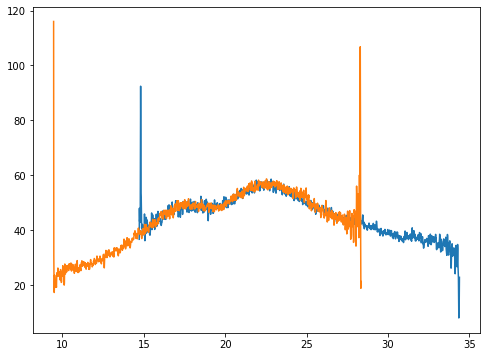

In [88]:
#Sanity check
print(len(b_indices))
test= np.linspace(np.min(b_indices), np.max(b_indices), np.max(b_indices)-np.min(b_indices)+1) # something Rahul did. Ask him for more. Hes being a meanie and not explaining properly
print(np.sum(b_indices-test))
q0_ovelap_mean = np.nanmean(y0[a_indices])
q1_ovelap_mean = np.nanmean(y1[b_indices])
ratio_q1_q0 = q1_ovelap_mean/q0_ovelap_mean
print(ratio_q1_q0)
plt.plot(x0, y0, x1, y1/ratio_q1_q0)

900
0.0
8.392044


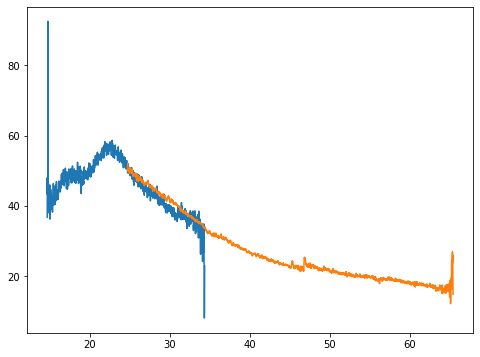

In [89]:
_, a_indices, b_indices = overlapfunc(x0,x3)
print(len(b_indices))
test= np.linspace(np.min(b_indices), np.max(b_indices), np.max(b_indices)-np.min(b_indices)+1) # something Rahul did. Ask him for more. Hes being a meanie and not explaining properly
print(np.sum(b_indices-test))
q0_ovelap_mean = np.nanmean(y0[a_indices])
q3_ovelap_mean = np.nanmean(y3[b_indices])
ratio_q3_q0 = q3_ovelap_mean/q0_ovelap_mean
print(ratio_q3_q0)
plt.plot(x0, y0, x3, y3/ratio_q3_q0)

1893
0.0
0.6376392


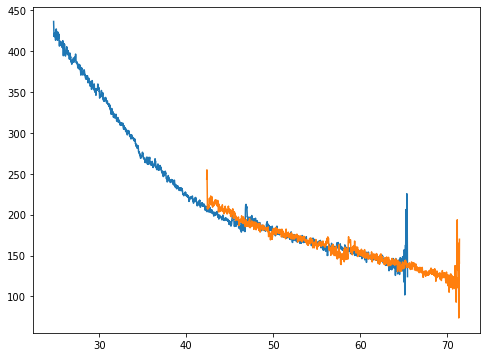

In [90]:
_, a_indices, b_indices = overlapfunc(x2,x3)
print(len(b_indices))
test= np.linspace(np.min(b_indices), np.max(b_indices), np.max(b_indices)-np.min(b_indices)+1) # something Rahul did. Ask him for more. Hes being a meanie and not explaining properly
print(np.sum(b_indices-test))
q2_ovelap_mean = np.nanmean(y2[a_indices])
q3_ovelap_mean = np.nanmean(y3[b_indices])
ratio_q2_q3 = q2_ovelap_mean/q3_ovelap_mean
print(ratio_q2_q3)
plt.plot(x3, y3, x2, y2/ratio_q2_q3)

## Quad Stitching

In [91]:
Int_keys

['Run 446', 'Run 600', 'Run 612', 'Run 615', 'Run 606', 'Run 609', 'Run 603']

In [92]:
Runs

[446, 600, 612, 615, 606, 609, 603]

In [93]:

final_ratios_quad_stitch = dict.fromkeys(Int_keys) 
for i, _ in enumerate(Runs):
    x_list = []
    y_list = []
    for j, _ in enumerate(Quads):
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
        x_list.append(x)
        y_list.append(y)

    _, a1_indices, b1_indices = overlapfunc(x_list[0],x_list[1])
    _, a2_indices, b2_indices = overlapfunc(x_list[0],x_list[3])
    _, a3_indices, b3_indices = overlapfunc(x_list[2],x_list[3])
    
    q2_ovelap_mean = np.nanmean(y2[a_indices])
    q3_ovelap_mean = np.nanmean(y3[b_indices])
    ratio_q2_q3 = q2_ovelap_mean/q3_ovelap_mean
    
    ratio_q1_q0 = np.nanmean(y_list[1][b1_indices])/np.nanmean(y_list[0][a1_indices])
    ratio_q3_q0 = np.nanmean(y_list[3][b2_indices])/np.nanmean(y_list[0][a2_indices])
    y_list[3] = y_list[3]/ratio_q3_q0
    ratio_q3_q2 = np.nanmean(y_list[3][b3_indices])/np.nanmean(y_list[2][a3_indices])
    
    final_ratios_quad_stitch[Int_keys[i]] = [ratio_q1_q0, ratio_q3_q0, ratio_q3_q2]
    # _, a_indices, b_indices = overlapfunc(x0,x1)
    

In [94]:
final_ratios_quad_stitch

{'Run 446': [1.0005797, 8.73368, 0.18198165],
 'Run 600': [0.9873141, 6.366076, 0.24353173],
 'Run 612': [0.9992522, 8.621522, 0.18598497],
 'Run 615': [0.9723668, 7.0903554, 0.20090652],
 'Run 606': [0.99893415, 7.4348702, 0.21580216],
 'Run 609': [0.9921889, 8.392044, 0.18687755],
 'Run 603': [0.99510473, 8.02919, 0.1985522]}

In [95]:
quad_2_plot = 3
calib_all['Calib Quad'+str(quad_2_plot)]

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 7.206540e-11m
SampleDetDist= 1.019933e-01m	PONI= 5.014607e-02, 5.434908e-03m	rot1=0.475808  rot2= -0.002768  rot3= 0.000005 rad
DirectBeamDist= 114.739mm	Center: x=-471.217, y=498.285 pix	Tilt=27.262 deg  tiltPlanRotation= -179.654 deg

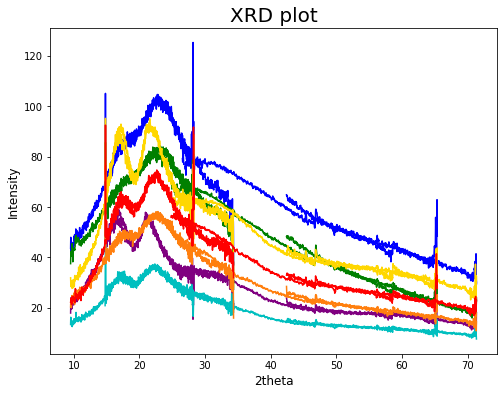

In [96]:
# plotting intergrated results for any Run and all quads
filter_sigma = 1
#Runs1 = [140, 141, 144, 147, 150, 153, 161, 164]
for i, _ in enumerate(Runs): 
    for j, _ in enumerate(Quads):
        if j == 0:
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = scipy.ndimage.gaussian_filter1d (Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1], sigma=filter_sigma)
            plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[i]) 
        elif j == 1:
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = scipy.ndimage.gaussian_filter1d (Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]/final_ratios_quad_stitch[Int_keys[i]][0], sigma=filter_sigma)
            plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[i])
        elif j == 2:
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = scipy.ndimage.gaussian_filter1d (Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]*final_ratios_quad_stitch[Int_keys[i]][2], sigma=filter_sigma)
            plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j),color = clr[i]) 
        elif j == 3:
            x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
            y = scipy.ndimage.gaussian_filter1d (Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]/final_ratios_quad_stitch[Int_keys[i]][1], sigma=filter_sigma) 
            plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j),color = clr[i]) 
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('2theta', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# max(Integresults[1])

In [97]:
i = 0
j = 3
x=Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
print('shape:', np.shape(x))
print('max: ', np.max(x))
print('min: ', np.min(x))
range = np.max(x) - np.min(x)
density = np.shape(x)[0]/range
print('density:', density)

# you know what meera? All of the shapes are what you fucking set in the fucking bin! you binned 2000!

shape: (3302,)
max:  65.49205447837163
min:  24.217699174821053
density: 80.0012495825937


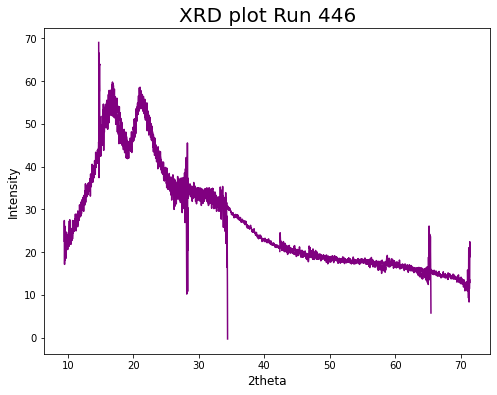

In [105]:
# plotting intergrated results for any Run and all quads

i = 0
for j in Quads:
    if j == 0:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[i]) 
    elif j == 1:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]/final_ratios_quad_stitch[Int_keys[i]][0]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j), color = clr[i])
    elif j == 2:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]*final_ratios_quad_stitch[Int_keys[i]][2]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j),color = clr[i]) 
    elif j == 3:
        x = Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][0]
        y = Int_1D_results['Run ' +str(Runs[i])]['Quad' + str(j) ][1]/final_ratios_quad_stitch[Int_keys[i]][1]
        plt.plot(x, y, label = 'Run ' + str(Runs[i])+ ' Quad' + str(j),color = clr[i]) 
    # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
    # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
    # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('2theta', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot Run ' +str(Runs[i]), fontsize = 20)
#plt.ylim([0, 20])
# plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# max(Integresults[1])

## Caked Images (2D intergration)

In [304]:
## Azimuthal integration
Int_keys = []
Int_quad_keys = []
for j in Runs:
   keys = 'Run ' + str((j))
   Int_keys.append(keys)
Int_2D_results = dict.fromkeys(Int_keys) 

for i in Quads:
   keys = 'Quad' + str((i))
   Int_quad_keys.append(keys)

counter = 0
   
for j in Runs:
   Int_2D_quads = dict.fromkeys(Int_quad_keys)
   for i in Quads:
      img = Run_images['Run ' + str(j)]['Quad'+ str(i)]
      mask_1 = Run_images['Run ' + str(j)]['Quad'+ str(i)] != 0.0 # masks out the low pixels(<1) (areas between the modules) (i.e these values are true)
      mask_2 = Run_images['Run ' + str(j)]['Quad'+ str(i)] < 500 ## masks out the hot pixels (>500) (areas between the modules)(i.e these values are true)
      mask_edge = np.full(np.shape(img), True)
      mask_edge[0:edge_mask_width, :] = False
      mask_edge[-edge_mask_width:-1, :] = False
      mask_edge[:, 0:edge_mask_width] = False    # areas which are false are zeros and true is one. 
      mask_edge[:, -edge_mask_width:-1] = False
      
      if i == 0:
         mask = mask_1 & mask_2 & mask_tri
      else:
         mask = mask_1 & mask_2 & mask_edge
      mask = mask.astype('float')
      mask[mask == 0] = np.nan
      calib_all['Calib Quad' + str(i)].wavelength = lams[counter]
      
      dark = dark_run_images['Run 124'] ["Quad"+ str(i)]
      
      Integ_results = calib_all['Calib Quad' + str(i)].integrate2d(img*mask-dark, 2000, 360, unit="2th_deg", polarization_factor=0.99, method='full_csr') # remember to put 
      Integ_results[1][Integ_results[1] == 0] = np.nan
      
      Int_2D_quads['Quad' + str((i))] =  Integ_results
   Int_2D_results['Run ' + str((j))] = Int_2D_quads
   counter = counter + 1
      
#print(Int_1D_results)

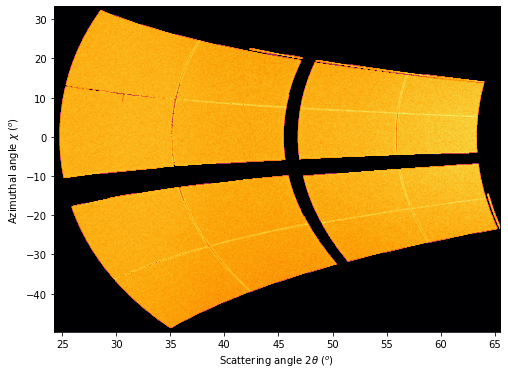

In [75]:
from pyFAI.gui import jupyter
run_to_plot = 'Run 416'

quad_2_plot = 3
ax = jupyter.plot2d (Int_2D_results[run_to_plot]["Quad{0}".format(quad_2_plot)])


Text(0.5, 1.0, 'XRD plot Run Run 416 Quad3')

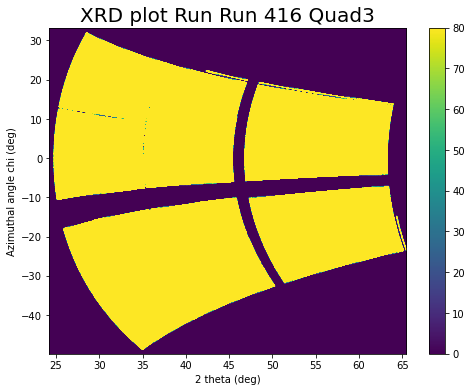

In [77]:
I, tth, chi = Int_2D_results[run_to_plot]["Quad{0}".format(quad_2_plot)]
plt.imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto", vmin=0, vmax = 80)
plt.xlabel("2 theta (deg)")
plt.ylabel("Azimuthal angle chi (deg)")
plt.colorbar()
plt.title('XRD plot Run ' +str(run_to_plot)+ ' Quad'+ str(quad_2_plot), fontsize = 20)


# Extra Stuff for Checking if we want to offset or scale?

### Offset or scaling?

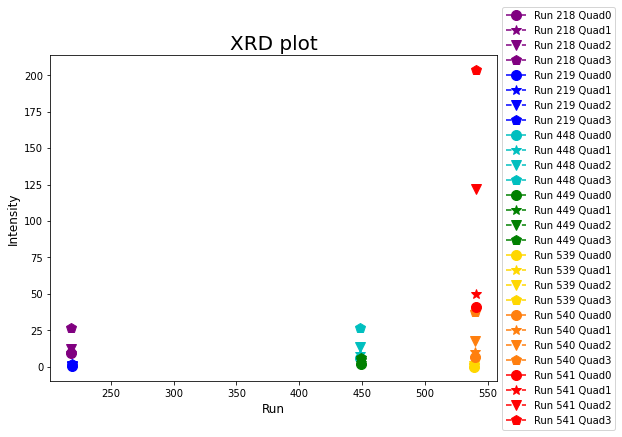

In [68]:
# plotting the mean of each against the run numbers

clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
sym = ['o', '*', 'v', 'p'] 
for i in range (len(Runs)): 
    for j in Quads:
        plt.plot (Runs[i], np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]), sym[j], markersize = 10, color = clr[i], linestyle = 'dashed', label = 'Run ' + str(Runs[i])+ ' Quad' + str(j) ) #color = clr[j])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('Run', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

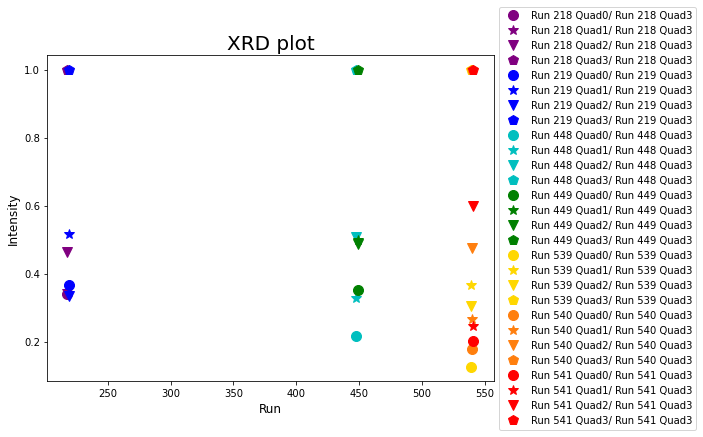

In [69]:
## plotting each quad divided by Quad 3
# plotting the mean of each against the run numbers
# color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
# clr = [random.choice(color) for i in range(50)]
clr = ['purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink','purple','deeppink','purple', 'b', 'c', 'g', 'gold','tab:orange','red','purple','deeppink'] 
sym = ['o', '*', 'v', 'p'] 
for i in range (len(Runs)): 
    for j in Quads:
        plt.plot (Runs[i], (np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad' + str(j)][1]))/(np.nanmean(Int_1D_results['Run ' + str(Runs[i])]['Quad3'][1])), sym[j], color = clr[i], markersize = 10,  label = 'Run ' + str(Runs[i]) + ' Quad' + str(j) + '/ Run ' +  str(Runs[i]) + ' Quad3') #color = clr[j])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad1'][0],Int_1D_results['Run ' +str(i)]['Quad1'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad2'][0],Int_1D_results['Run ' + str(i)]['Quad2'][1])
        # plt.plot(Int_1D_results['Run ' + str(i)]['Quad3'][0],Int_1D_results['Run ' +str(i)]['Quad3'][1])
plt.xlabel('Run', fontsize = 12)
plt.ylabel('Intensity', fontsize = 12) 
plt.title('XRD plot', fontsize = 20)
#plt.ylim([0, 50])
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
